## 데이터
일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를 이용하여 Numpy 배열로 불러오고, 그 후 torch.*Tensor로 변환
* 이미지는 Pilow나 OpenCV
* 오디오를 처리 할 때는 SciPy와 LibROSA
* 텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SPaCy도 유용

## 이미지 분류기 학습
* torchvision을 사용하여 CIFAR10의 Train/Test Data Set을 불러오고 정규화
* 합성곱 신경망(Convolution Neural Network) 정의
* 손실 함수 정의
* Train Data를 사용하여 신경망 학습
* Test Data를 사용하여 신경망 검사

#### 데이터 로드
torchvision은 CIFAR10을 쉽게 불러올 수 있음

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
           'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


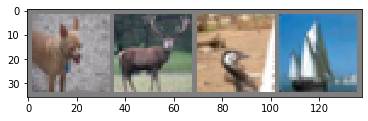

  dog  deer  bird  ship


In [4]:
import matplotlib.pyplot as plt
import numpy as np


# 이미지를 보여주는 함수
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 학습용 이미지를 무작위로 추출
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### 합성곱 신경망(Convolution Neural Network) 정의

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


#### 손실함수와 Optimizer 정의
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(Momentum)값을 갖는 SGD 사용

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [input, label]의 목록인 data로부터 입력을 받음
        inputs, labels = data
        
        # 변화도(Gradient) 배개변수를 0으로 초기화
        optimizer.zero_grad()
        
        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 통계를 출력
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
            
print('Finish Training')

[1,  2000] loss: 2.268
[1,  4000] loss: 1.927
[1,  6000] loss: 1.725
[1,  8000] loss: 1.625
[1, 10000] loss: 1.546
[1, 12000] loss: 1.488
[2,  2000] loss: 1.403
[2,  4000] loss: 1.371
[2,  6000] loss: 1.329
[2,  8000] loss: 1.315
[2, 10000] loss: 1.282
[2, 12000] loss: 1.278
Finish Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### 신경망 테스트

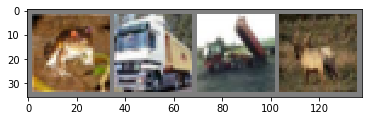

GroundTruth:   frog truck truck  deer


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))    # 모델 불러오기

<All keys matched successfully>

In [11]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' %classes[predicted[j]] for j in range(4)))

Predicted:    cat truck truck  deer


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10,000 test images: %d %%'
      %(100*correct / total))

Accuracy of the network on the 10,000 test images: 58 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s: %2d %%' 
          %(classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane: 69 %
Accuracy of   car: 75 %
Accuracy of  bird: 36 %
Accuracy of   cat: 44 %
Accuracy of  deer: 58 %
Accuracy of   dog: 39 %
Accuracy of  frog: 62 %
Accuracy of horse: 64 %
Accuracy of  ship: 75 %
Accuracy of truck: 63 %
